# Polarized observations

This tutorial covers working with polarized instrument and maps, and recovering polarized maps from observations.

We start with a normal instrument, and create two orthogonally polarized copies of each detector by setting ``polarized: True`` in the ``Array`` config:

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

array = {"field_of_view": 0.5, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 10, 
         "polarized": True,
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)
instrument.arrays

,n,FOV,baseline,bands,polarized
array1,652,28.68’,0 m,"[f090,f150]",True


We can see the resulting polarization footprint in the instrument plot:

Instrument(1 array)
├ arrays:
│            n     FOV baseline        bands polarized
│  array1  652  28.68’      0 m  [f090,f150]      True
│ 
└ bands:
      name   center   width    η         NEP   NET_RJ     NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s   1.458’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s  0.8748’


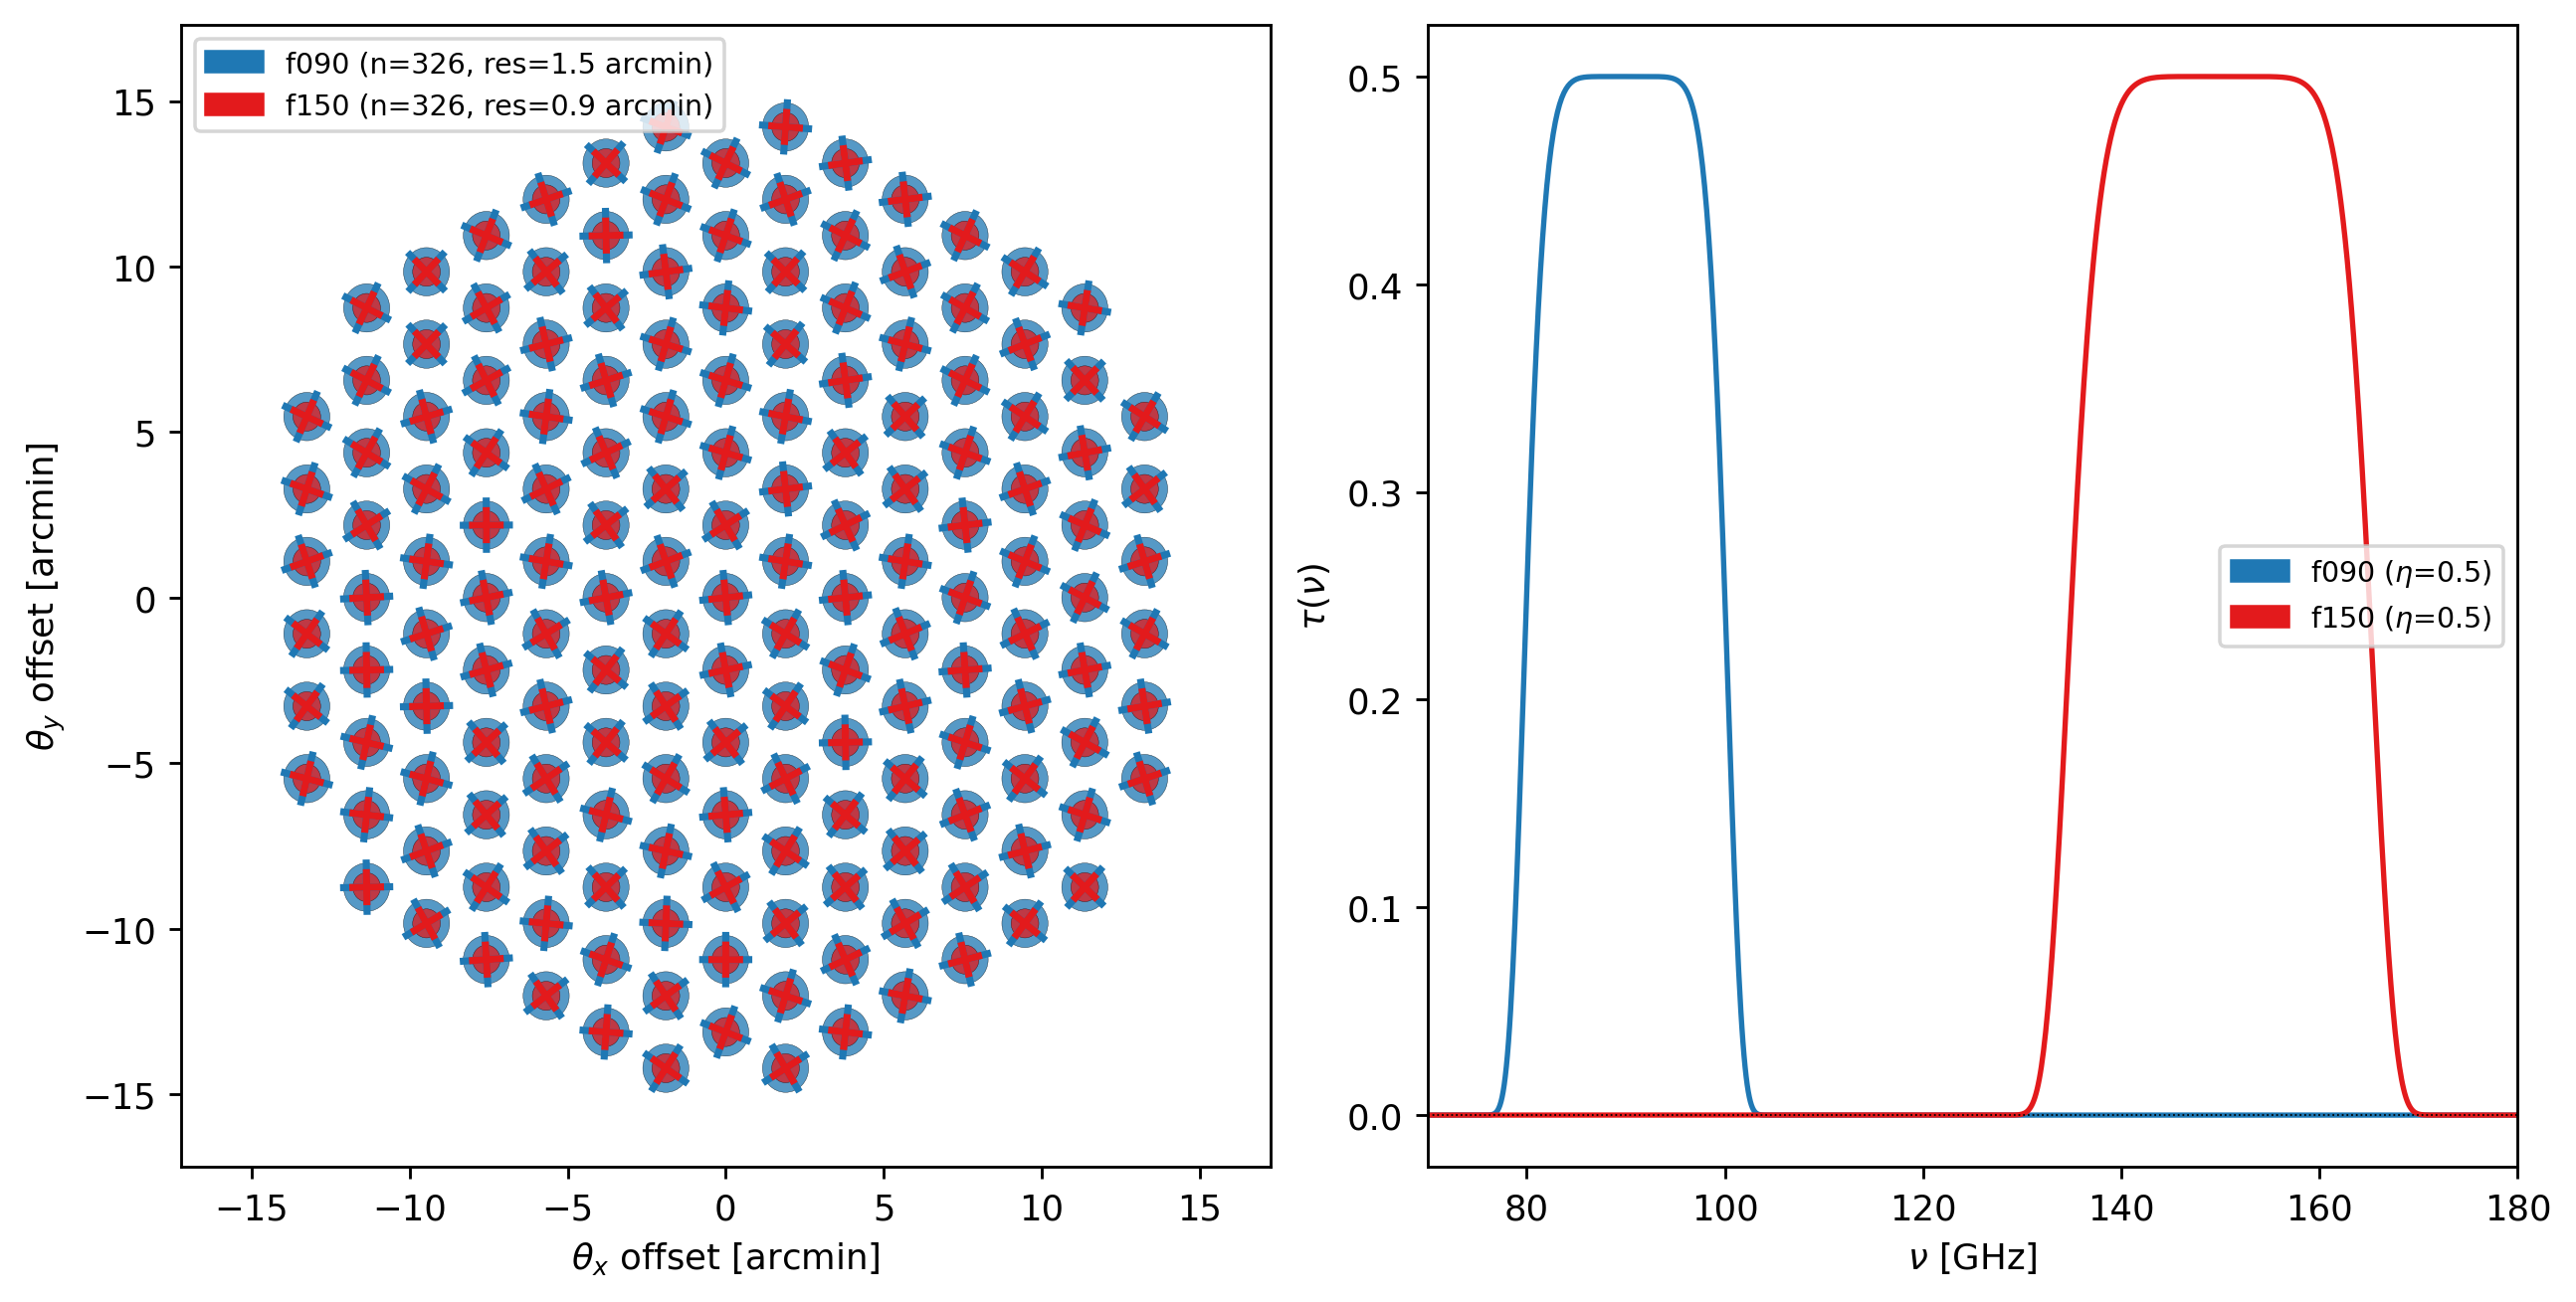

In [2]:
print(instrument)
instrument.plot()

Let's observe the use the Einstein map, which has a faint polarization signature underneath the unpolarized signal of Einstein's face. Remember that all maps are five dimensional (stokes, frequency, time, y, x); this map has four channels in the stokes dimensions (the I, Q, U, and V [Stokes parameters](https://en.wikipedia.org/wiki/Stokes_parameters)). We can plot all the channels by giving ``plot`` a shaped set of stokes parameters.

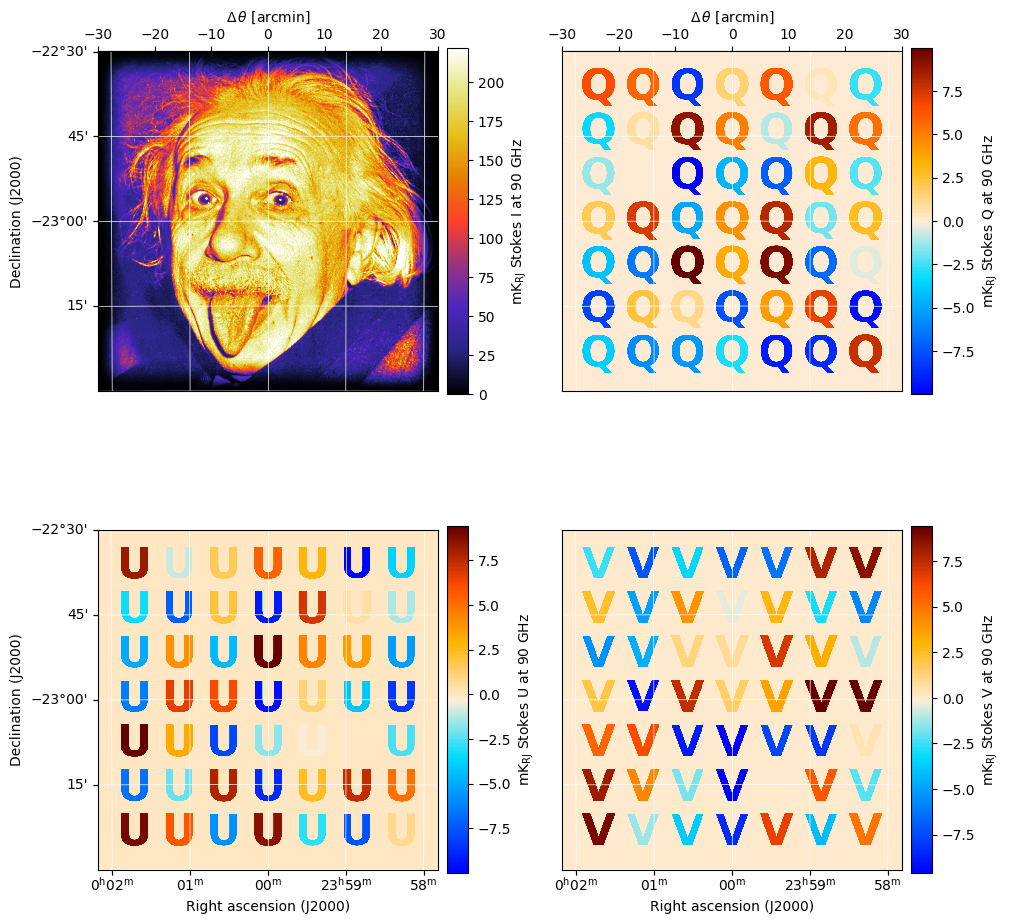

In [3]:
from maria.io import fetch

input_map = maria.map.load(fetch("maps/einstein.h5"))
input_map.plot(stokes=[["I", "Q"], 
                       ["U", "V"]])

Plan:
  start_time: 2024-08-06 03:00:00.000 +00:00
  duration: 900 s
  sample_rate: 50 Hz
  center:
    ra: 00ʰ00ᵐ0.00ˢ
    dec: -23°00’0.00”
  scan_pattern: daisy
  scan_radius: 0.9989°
  scan_kwargs: {'radius': 0.5, 'speed': 0.1}


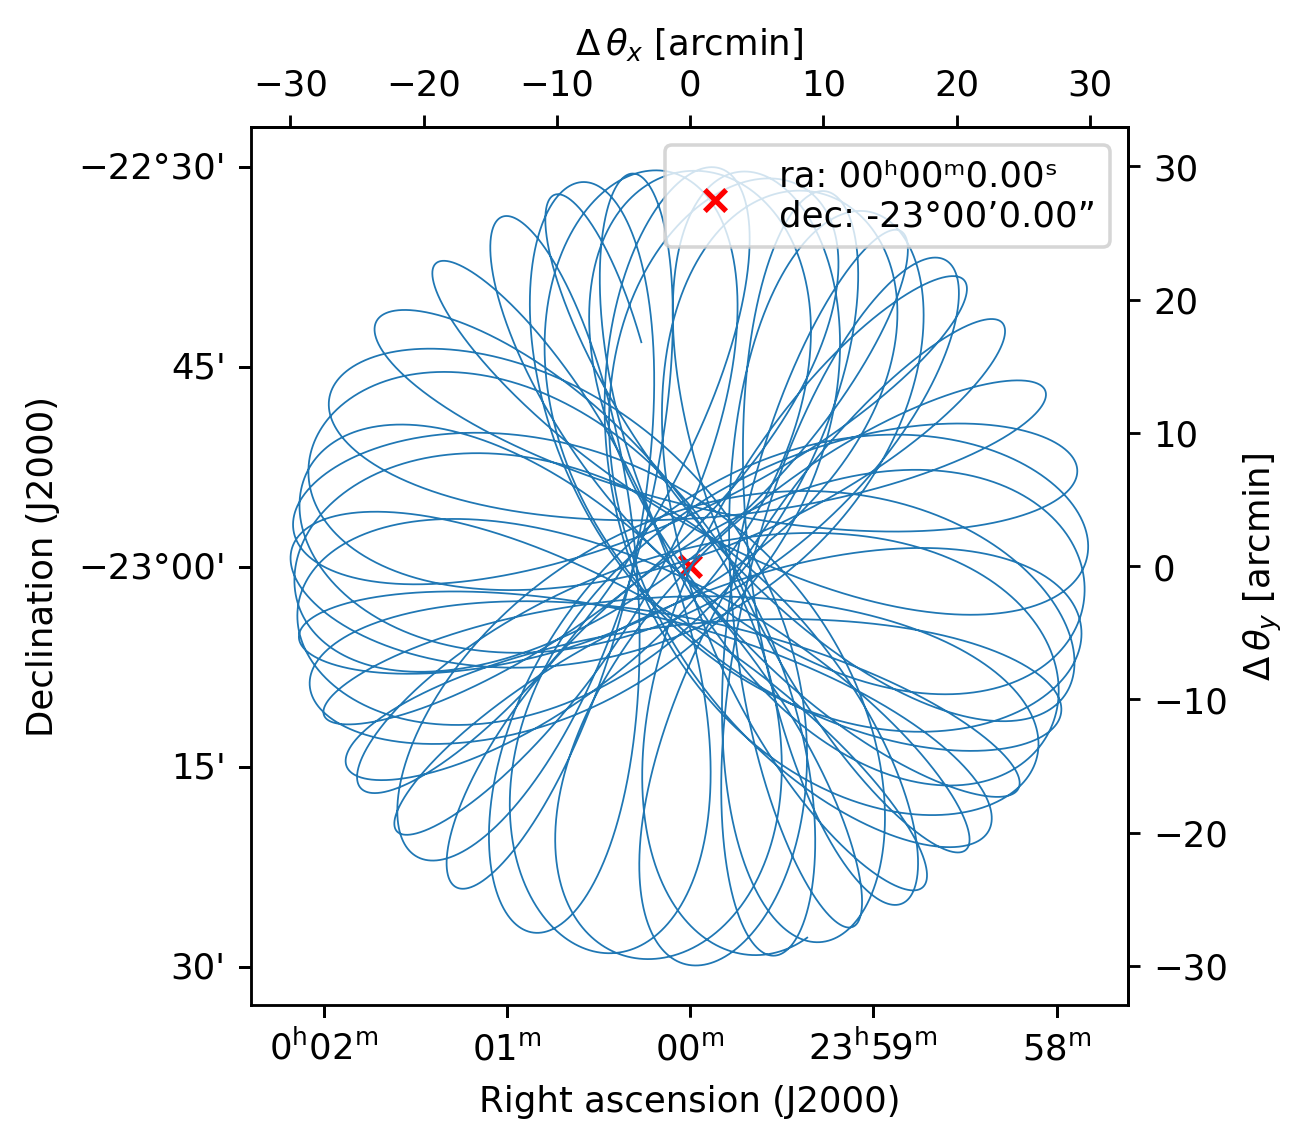

In [4]:
plan = maria.Plan(
    start_time="2024-08-06T03:00:00",
    scan_pattern="daisy",
    scan_options={"radius": 0.5, "speed": 0.1},  # in degrees
    duration=900,  # in seconds
    sample_rate=50,  # in Hz
    scan_center=(0, -23),
    frame="ra_dec")

print(plan)
plan.plot()

In [5]:
sim = maria.Simulation(
    instrument,
    plan=plan,
    site="llano_de_chajnantor",
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map
)

print(sim)

Constructing atmosphere:   0%|          | 0/10 [00:00<?, ?it/s]

Constructing atmosphere:  10%|█         | 1/10 [00:04<00:37,  4.21s/it]

Constructing atmosphere:  20%|██        | 2/10 [00:07<00:27,  3.42s/it]

Constructing atmosphere:  30%|███       | 3/10 [00:11<00:26,  3.75s/it]

Constructing atmosphere:  40%|████      | 4/10 [00:14<00:22,  3.76s/it]

Constructing atmosphere:  50%|█████     | 5/10 [00:18<00:17,  3.54s/it]

Constructing atmosphere:  60%|██████    | 6/10 [00:22<00:14,  3.71s/it]

Constructing atmosphere:  70%|███████   | 7/10 [00:25<00:10,  3.50s/it]

Constructing atmosphere:  80%|████████  | 8/10 [00:28<00:06,  3.29s/it]

Constructing atmosphere:  90%|█████████ | 9/10 [00:31<00:03,  3.20s/it]

Constructing atmosphere: 100%|██████████| 10/10 [00:34<00:00,  3.11s/it]

Constructing atmosphere: 100%|██████████| 10/10 [00:34<00:00,  3.40s/it]

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │            n     FOV baseline        bands polarized
│ │  array1  652  28.68’      0 m  [f090,f150]      True
│ │ 
│ └ bands:
│       name   center   width    η         NEP   NET_RJ     NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s   1.458’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s  0.8748’
├ Site:
│   region: chajnantor
│   location: 23°01’45.84”S 67°45’17.28”W
│   altitude: 5064 m
│   seasonal: True
│   diurnal: True
├ Plan:
│   start_time: 2024-08-06 03:00:00.000 +00:00
│   duration: 900 s
│   sample_rate: 50 Hz
│   center:
│     ra: 00ʰ00ᵐ0.00ˢ
│     dec: -23°00’0.00”
│   scan_pattern: daisy
│   scan_radius: 0.9989°
│   scan_kwargs: {'radius': 0.5, 'speed': 0.1}
├ Atmosphere(10 processes with 10 layers):
│ ├ spectrum:
│ │   region: chajnantor
│ └ weather:
│     region: chajnantor
│     altitude: 5064 m
│     time: Aug 5 23:07:29 -04:00
│     pwv[mean, rms]: (0.5 mm, 15 

Generating turbulence:   0%|          | 0/10 [00:00<?, ?it/s]

Generating turbulence:  30%|███       | 3/10 [00:00<00:00, 20.41it/s]

Generating turbulence:  60%|██████    | 6/10 [00:00<00:00, 12.60it/s]

Generating turbulence:  80%|████████  | 8/10 [00:00<00:00,  9.24it/s]

Generating turbulence: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]

Generating turbulence: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]

Sampling turbulence:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling turbulence:  10%|█         | 1/10 [00:01<00:10,  1.21s/it]

Sampling turbulence:  20%|██        | 2/10 [00:01<00:07,  1.10it/s]

Sampling turbulence:  30%|███       | 3/10 [00:02<00:05,  1.20it/s]

Sampling turbulence:  40%|████      | 4/10 [00:03<00:04,  1.23it/s]

Sampling turbulence:  50%|█████     | 5/10 [00:04<00:03,  1.26it/s]

Sampling turbulence:  60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

Sampling turbulence:  70%|███████   | 7/10 [00:05<00:02,  1.30it/s]

Sampling turbulence:  80%|████████  | 8/10 [00:06<00:01,  1.29it/s]

Sampling turbulence:  90%|█████████ | 9/10 [00:07<00:00,  1.29it/s]

Sampling turbulence: 100%|██████████| 10/10 [00:08<00:00,  1.28it/s]

Sampling turbulence: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:02<00:02,  2.93s/it, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:02<00:02,  2.93s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it, band=f150]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Sampling map:   0%|          | 0/2 [00:02<?, ?it/s, channel=[ 0. inf] Hz]

Sampling map:  50%|█████     | 1/2 [00:05<00:05,  5.44s/it, channel=[ 0. inf] Hz]

Sampling map:  50%|█████     | 1/2 [00:05<00:05,  5.44s/it, band=f150]           

Sampling map:  50%|█████     | 1/2 [00:07<00:05,  5.44s/it, channel=[ 0. inf] Hz]

Sampling map: 100%|██████████| 2/2 [00:10<00:00,  5.37s/it, channel=[ 0. inf] Hz]

Sampling map: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it, channel=[ 0. inf] Hz]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, band=f090]

Generating noise:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, band=f150]

Generating noise: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s, band=f150]

Generating noise: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s, band=f150]

TOD(shape=(652, 45000), fields=['atmosphere', 'map', 'noise'], units='pW', start=2024-08-06 03:14:59.979 +00:00, duration=900.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-06-20T14:49:24.350165+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 272.523})


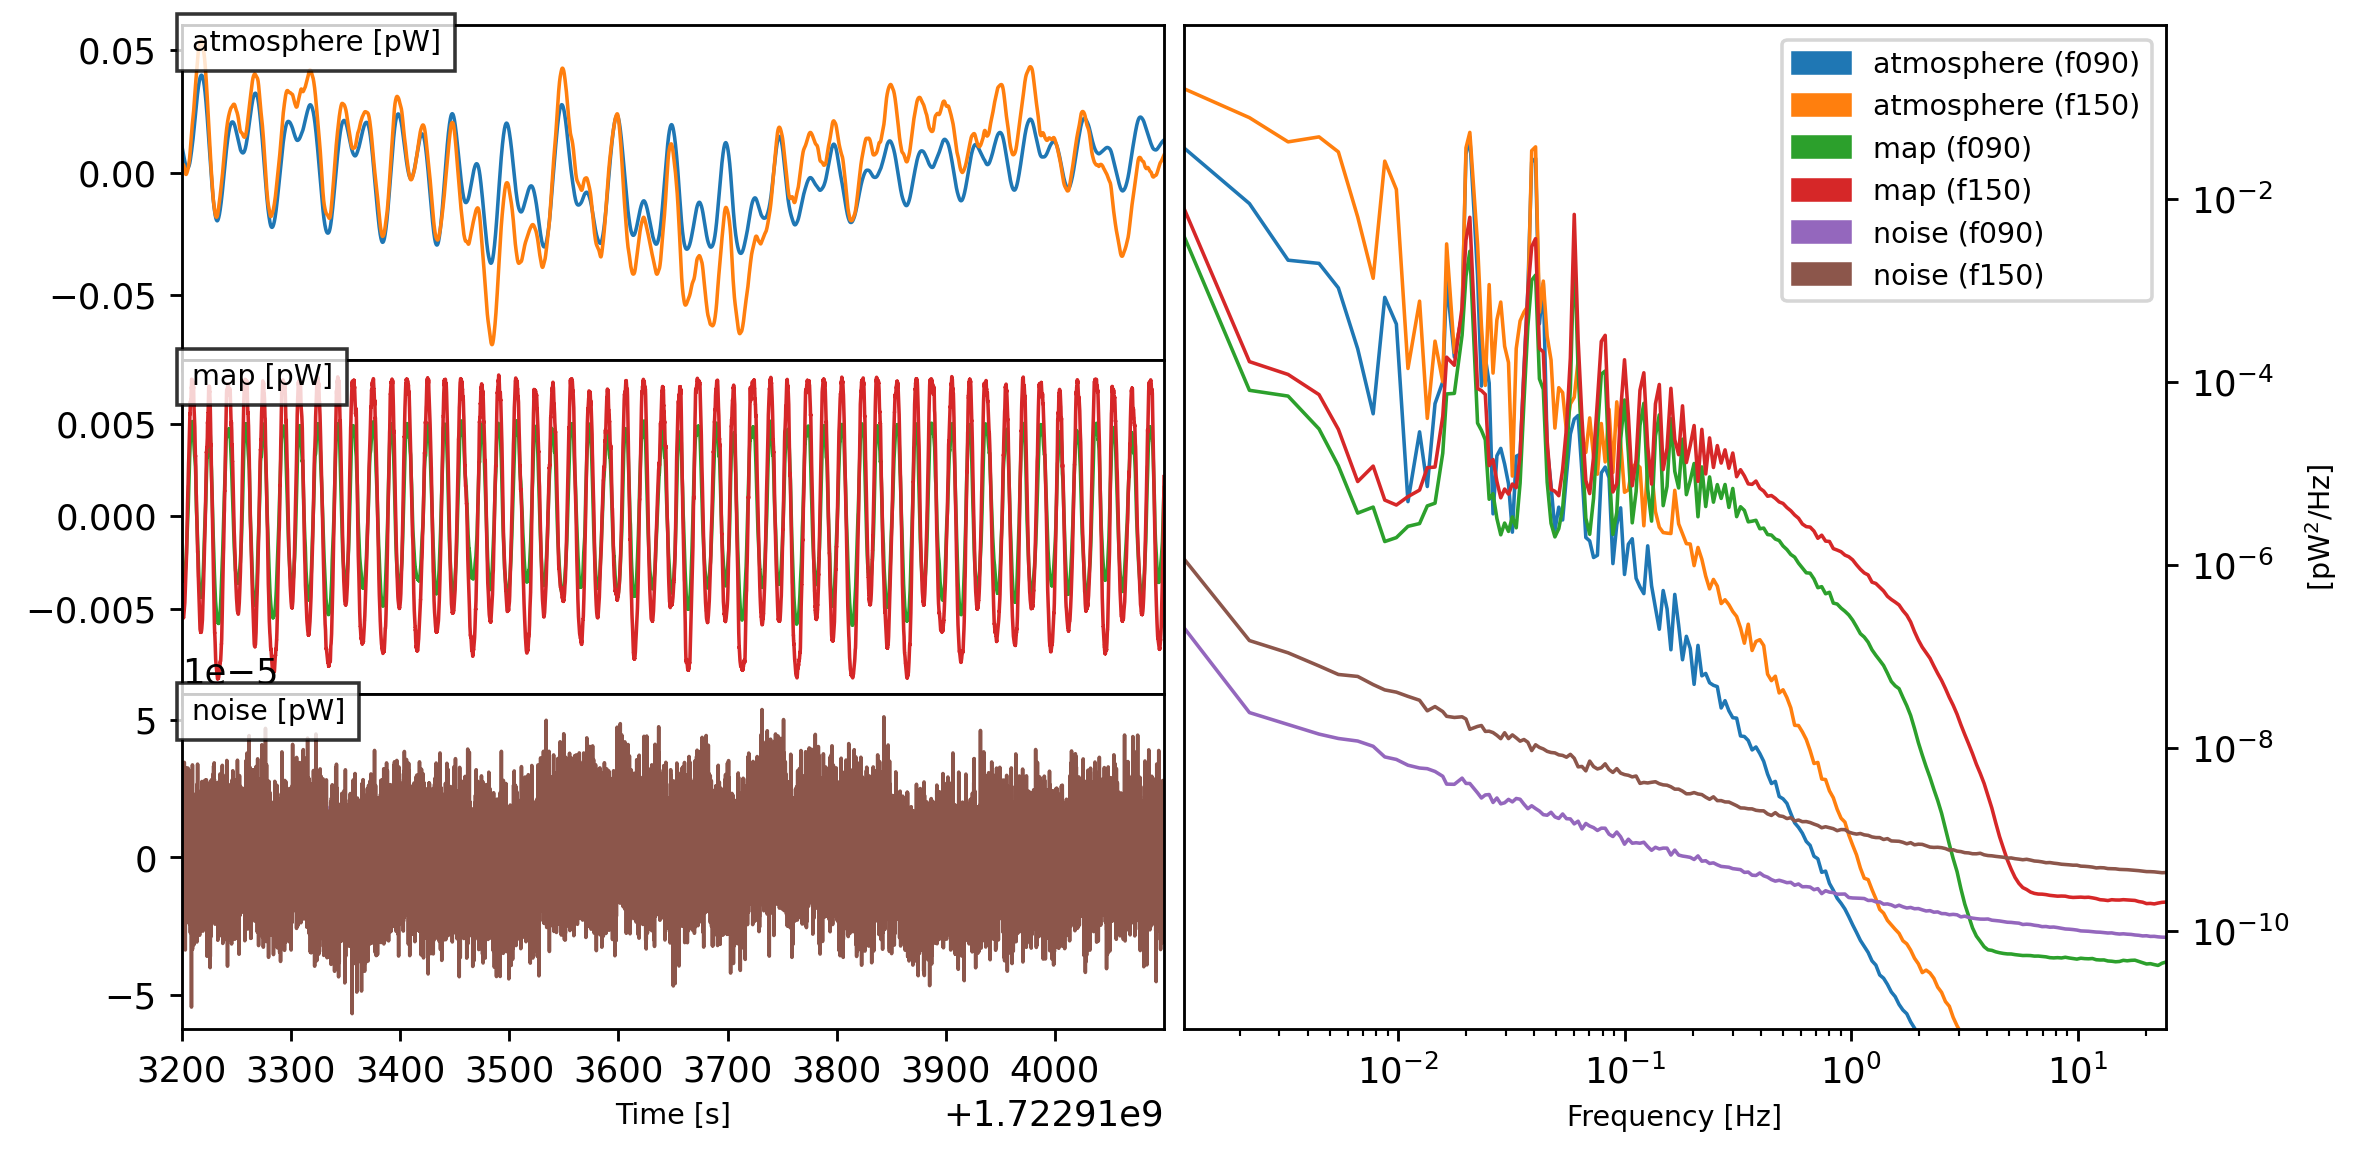

In [6]:
tod = sim.run()

print(tod)
tod.plot()

In [7]:
from maria.mappers import BinMapper

mapper = BinMapper(
    center=(0, -23),
    stokes="IQU",
    frame="ra_dec",
    width=1.0,
    height=1.0,
    resolution=1.0 / 256,
    tod_preprocessing={
        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
        "remove_spline": {"knot_spacing": 30, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": [0]},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
        # "median_filter": {"size": 1},
    },
    units="mK_RJ",
)

mapper.add_tods(tod)

output_map = mapper.run()

print(output_map)

Mapping band f090:   0%|          | 0/3 [00:00<?, ?it/s]

Mapping band f090:   0%|          | 0/3 [00:00<?, ?it/s, band=f090, stokes=I]

Mapping band f090:  33%|███▎      | 1/3 [00:00<00:00,  7.53it/s, band=f090, stokes=I]

Mapping band f090:  33%|███▎      | 1/3 [00:00<00:00,  7.53it/s, band=f090, stokes=Q]

Mapping band f090:  67%|██████▋   | 2/3 [00:00<00:00,  7.50it/s, band=f090, stokes=Q]

Mapping band f090:  67%|██████▋   | 2/3 [00:00<00:00,  7.50it/s, band=f090, stokes=U]

Mapping band f090: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s, band=f090, stokes=U]

Mapping band f090: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, band=f090, stokes=U]


2025-06-20 14:49:35.450 INFO: Ran mapper for band f090 in 6.908 s.


Mapping band f150:   0%|          | 0/3 [00:00<?, ?it/s]

Mapping band f150:   0%|          | 0/3 [00:00<?, ?it/s, band=f150, stokes=I]

Mapping band f150:  33%|███▎      | 1/3 [00:00<00:00,  9.26it/s, band=f150, stokes=I]

Mapping band f150:  33%|███▎      | 1/3 [00:00<00:00,  9.26it/s, band=f150, stokes=Q]

Mapping band f150:  67%|██████▋   | 2/3 [00:00<00:00,  9.23it/s, band=f150, stokes=Q]

Mapping band f150:  67%|██████▋   | 2/3 [00:00<00:00,  9.23it/s, band=f150, stokes=U]

Mapping band f150: 100%|██████████| 3/3 [00:00<00:00,  9.25it/s, band=f150, stokes=U]

Mapping band f150: 100%|██████████| 3/3 [00:00<00:00,  9.22it/s, band=f150, stokes=U]


2025-06-20 14:49:42.294 INFO: Ran mapper for band f150 in 6.84 s.


ProjectedMap:
  shape(stokes, nu, y, x): (3, 2, 256, 256)
  stokes: IQU
  nu: [ 90. 150.] GHz
  t: naive
  z: naive
  quantity: rayleigh_jeans_temperature
  units: mK_RJ
    min: -1.168e+02
    max: 1.218e+02
  center:
    ra: 00ʰ00ᵐ0.00ˢ
    dec: -23°00’0.00”
  size(y, x): (1°, 1°)
  resolution(y, x): (14.06”, 14.06”)
  beam(maj, min, rot): (14.06”, 14.06”, 0°)
  memory: 6.291 MB


Note that we can't see any of the circular polarization, since our instrument isn't sensitive to it.

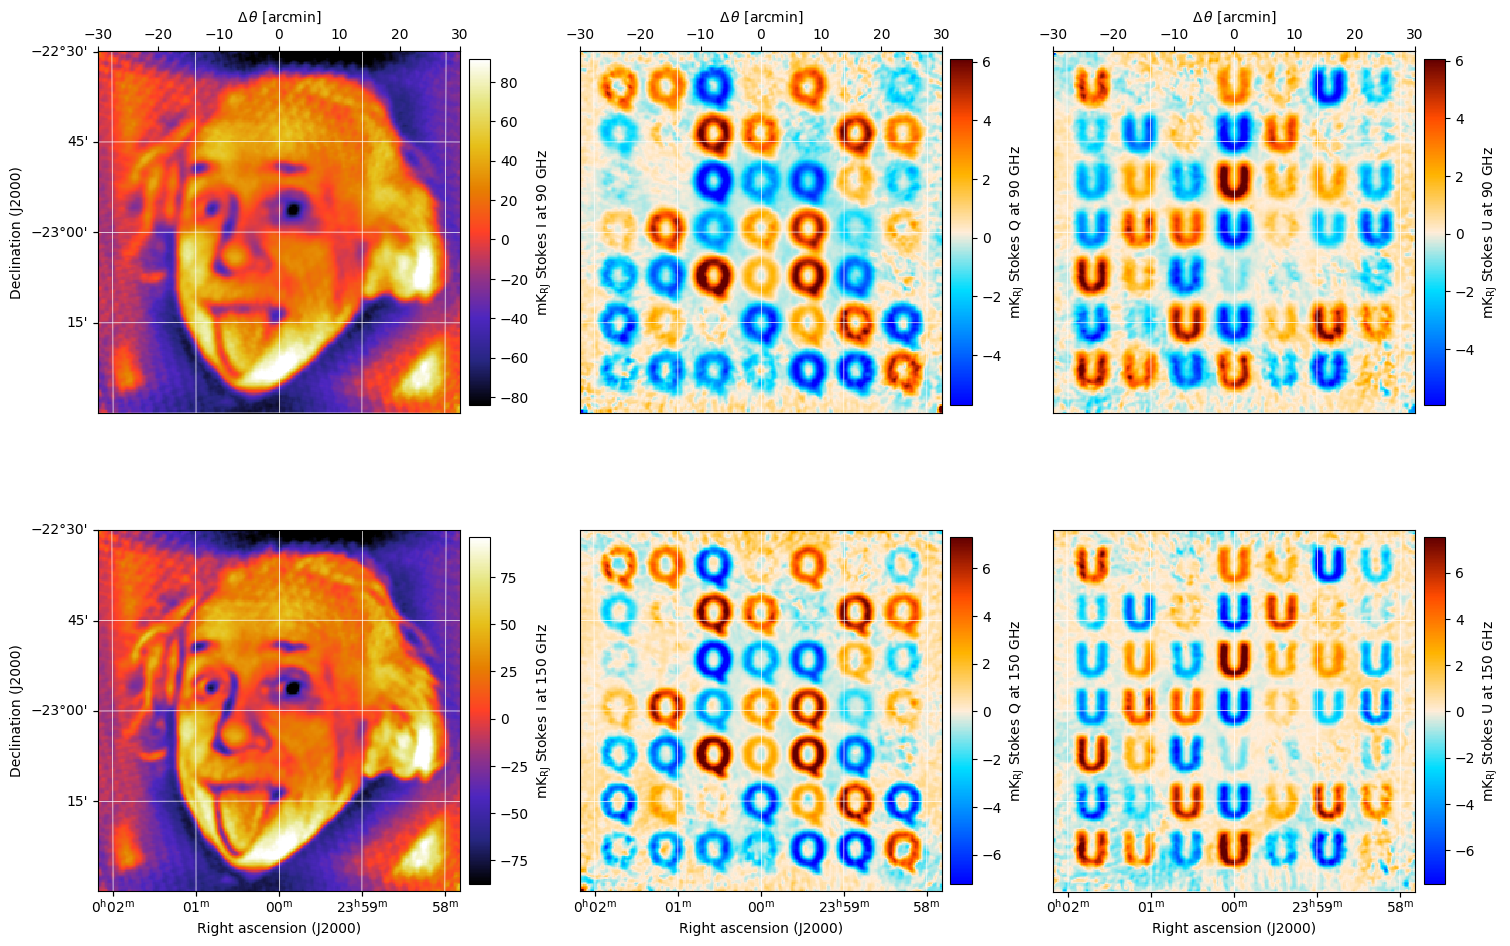

In [8]:
output_map.plot(stokes=["I", "Q", "U"], nu_index=[[0], [1]])